## Initial Attempt At Tissot's Indicatrix

This version uses a lot of libraries, but has an output closer to what I originall invsioned. The general workflow is as follows: 

1. Read in data from Natural Earth Data
2. Calculate graticulelines and then intersection points from lines, save in geopandas dataframe
3. Calculate scale factors for indicatrix axis
4. Project maps and indicatrices
5. Save

In [1]:
import pandas as pd 
import numpy as np
import shapefile

import geopandas as gpd
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from shapely.geometry import Polygon, Point, LineString

In [2]:
input_dir = 'data/'
output_dir = 'data/output/'
sf_name = "ne_110m_admin_0_countries.shp"

## Helper Fuctions

In [3]:
def get_base(input_dir, sf_name):
    """Read in and plot the base map."""
    base_map=gpd.read_file(input_dir + sf_name)
    base_map.plot()
    extremes = base_map.geometry.bounds
    return base_map, extremes


In [4]:
def create_grid(base_map, degree=30): 
    """Create a grid of given degree across the bounds of the map """
    points = base_map.geometry
    xmin, ymin, xmax, ymax = points.total_bounds

    length = degree
    wide = degree

    cols = list(np.arange(xmin, xmax + wide, wide)) 
    rows = list(np.arange(ymin+length, ymax+length, length)) # skip extremes on North and South Poles

    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            #polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))
            #polygons.append(LineString([Point(x, y), Point(x+wide, y+length)]))
            polygons.append(LineString([Point(x, y), Point(x+wide, y)]))
            polygons.append(LineString([Point(x, y), Point(x, y+length)]))


    grid = gpd.GeoDataFrame({'geometry':polygons})
    return grid 

In [5]:
def create_intersection_points(grid): 

    intersections_df = pd.DataFrame(columns=["geometry"])
    intersections = []

    gdf = grid
    
    # Iterate through each row and find intersection points , Modified from https://gist.github.com/maptastik/dc3d3b4514546310500a13fb77663bb9 
    for index, row in gdf.iterrows():
        row_intersections = gdf.intersection(row['geometry'])         # Get GeoSeries of intersections of row with all rows
        intersections.extend(row_intersections[row_intersections.geom_type == 'Point'].geometry)         # Keep only point intersections
        t = pd.DataFrame(intersections, index=None)

    t = t.rename({0: 'Coordinates'}, axis=1) # Fix to turn back into Geodataframe
    graticule_intersections_gdf = gpd.GeoDataFrame(t, geometry="Coordinates")
    graticule_intersections_gdf = graticule_intersections_gdf.set_crs(epsg=4326)
    return graticule_intersections_gdf


## Initial Plotting

## Generate Ellipsoids

In [6]:
def obtain_scale_factors(graticule_intersections_gdf, output_proj_epsg, h=None):
    """
    REDO TO BE POINT BASED ON DF BASED??
    phi  = latitude
    lambda = longitude


    y = projected latitude
    x = projected longidue 
    """

    lats = np.radians(graticule_intersections_gdf.geometry.y)
    lons = np.radians(graticule_intersections_gdf.geometry.x)
    
#     proj_code = output_proj_epsg #epsg code of the output projection 
#     base_code = 4326

#     if h is None: 
#         h = 10**(-5.2) 

#     first_proj = gpd.GeoSeries([Point(Point(point[0], point[1])) for point in zip(lats - h/2, lons)], crs="EPSG:{}".format(base_code)).to_crs(epsg = proj_code) #lat = point[0], lon = point[1]
#     second_proj = gpd.GeoSeries([Point(Point(point[0], point[1])) for point in zip(lats + h/2, lons)], crs="EPSG:{}".format(base_code)).to_crs(epsg = proj_code)
#     third_proj = gpd.GeoSeries([Point(Point(point[0], point[1])) for point in zip(lats, lons - h/2)], crs="EPSG:{}".format(base_code)).to_crs(epsg = proj_code)
#     fourth_proj = gpd.GeoSeries([Point(Point(point[0], point[1])) for point in zip(lats, lons + h/2)], crs="EPSG:{}".format(base_code)).to_crs(epsg = proj_code)

#     x0s, y0s = first_proj.geometry.x, first_proj.geometry.y
#     x1s, y1s = second_proj.geometry.x, second_proj.geometry.y
#     x2s, y2s = third_proj.geometry.x, third_proj.geometry.y
#     x3s, y3s = fourth_proj.geometry.x, fourth_proj.geometry.y

#     dx_phi = (x1s - x0s)/h 
#     dy_phi = (y1s - y0s) /h
#     dx_lambda = (x3s - x2s)/h
#     dy_lambda = (y3s - y2s)/h

#     # Adjust based on  reference system https://en.wikipedia.org/wiki/World_Geodetic_System#:~:text=The%20WGS%2084%20datum%20surface,%3D%201%2F298.257223563.
#     world_radius = {
#         4326: 6378137
#     }

#     R = world_radius[base_code]
    
#     # SNYDERS FORMULAS
#     sf_h = (1/R) * ( (dx_phi)**2  + (dy_phi)**2 )**1/2
#     sf_k =  (1/R*cos(lats)) * ((dx_lambda)**2 + (dy_lambda)**2)**1/2
    

    # Cylindrical Projection
    if output_proj_epsg == 3395: 
        scale_factor_h = 1 / np.cos(lats.values)
        scale_factor_k = scale_factor_h

    # Equal Area Projection    
    if output_proj_epsg == 6933:
        scale_factor_h = np.cos(lats)
        scale_factor_k = 1 / scale_factor_h
    
    return scale_factor_h, scale_factor_k


## Example of Usage Start to Finish

x: -20037508.342789244, y: -12890914.137293588, x_scale: 1478593.7404583711,  y_scale: 1478593.7404583711 


<AxesSubplot:>

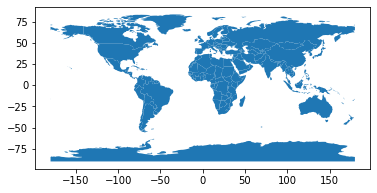

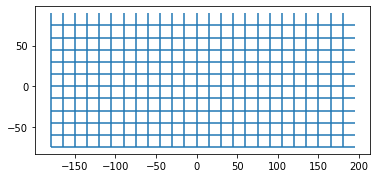

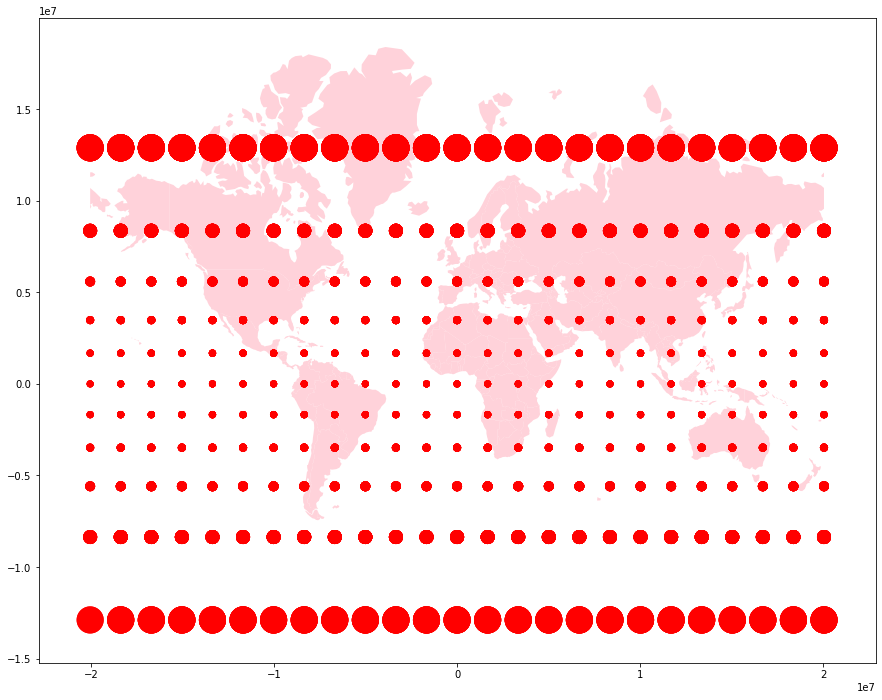

In [7]:
base_map, extremes = get_base(input_dir, "ne_110m_admin_0_countries/" + sf_name)
grid = create_grid(base_map, degree=15)
grid.plot()
graticule_intersections_gdf = create_intersection_points(grid)

indicatrices = []
ellipses = []
proj_code=3395

scale_factor_h, scale_factor_k = obtain_scale_factors(graticule_intersections_gdf, output_proj_epsg=proj_code, h=None)
for index, row in graticule_intersections_gdf.to_crs(epsg=proj_code).iterrows():
    x = row['Coordinates'].x
    y = row['Coordinates'].y
    base_size =  6378137 * .06
    x_scale = scale_factor_h[index] # along meridians
    y_scale = scale_factor_k[index] # along paralelles 
    e = Ellipse((x,y), base_size * x_scale , base_size * y_scale)

    if index is 0:
        print('x: {}, y: {}, x_scale: {},  y_scale: {} '.format(x, y, base_size*x_scale, base_size*y_scale))
    ellipses.append(e)
    # Transform into Polygon 
    vertices = e.get_verts()     # get the vertices from the ellipse object
    poly = Polygon(vertices)
    indicatrices.append(poly)
    
    
t = pd.DataFrame(indicatrices, index=None)
t = t.rename({0: 'Coordinates'}, axis=1) # Fix to turn back into Geodataframe
ti = gpd.GeoDataFrame(t, geometry="Coordinates")
ti = ti.set_crs(epsg=proj_code)

bm = base_map.to_crs(epsg=proj_code)
gi= graticule_intersections_gdf.to_crs(epsg=proj_code)
bm = bm[(base_map.ADMIN != "Antarctica") & (base_map.ADMIN != "Fr. S. Antarctic Lands")] # Remove because of projection extremes

fig, ax = plt.subplots(figsize=(15, 15))
bm.plot(ax=ax, alpha=0.7, color="pink")
ti.plot(ax=ax, color="red")

In [8]:
ti.to_file(output_dir + 'tissot_indicatrix_' + str(proj_code) + '.shp')